In [1]:
import dismech_nn
import torch
import matplotlib.pyplot as plt

C:\Users\12345\Documents\Dev\dismech_nn\dismech_nn\train.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Proximal Backwards Euler

A backwards Euler step is defined as the following

$y_{k+1}=y_k+\Delta t f(y_{k+1})$ where $\frac{dF}{dt}=f(y)$

The crux is how do you find $y_{k+1}$ such that the constraint holds?

A simple solution is to do gradient descent such that $z_{i+1}=z_{i}-\eta(\frac{z_{i}-y_{k}}{s}-f(z_{i}))$ where $z_{i}$ is the *i*th iteration

In [ ]:
def gd(f, y, z, dt, eta):
    return z - eta * ((z - y) / dt + f([], z))

We will halt when the previous and current guess are within a certain tolerance

In [9]:
def inner_step(f, yk, dt, eta, max_iter = 1000, tol=1e-5):
    y = yk.clone()
    for _ in range(max_iter):
        y_prev = y.clone()
        y = gd(f, yk, y_prev, dt, eta)
        if torch.norm(y - y_prev) <= tol:
            return y

Implementing the rest of a fixed-step solver is trivial once the inner step is done

In [11]:
def backwards_euler(f, y0, dt, count=100):
    y = y0
    ret = [y0]
    for i in range(count-1):
        y = inner_step(f, y, dt, eta=0.1)
        ret.append(y)
    return torch.stack(ret)

We use the transfer matrix from dismech_nn to test a mass spring damper with an obscenely large dt step

In [18]:
t = torch.arange(0.0, 30, step=0.1)
sol = backwards_euler(dismech_nn.MSD(1.0, 1.0, 0.), torch.tensor([1.0, 0.0]), 0.1, count=300)

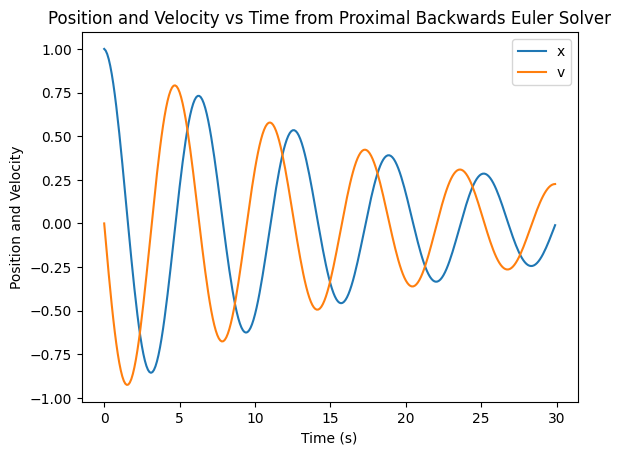

In [19]:
plt.plot(t, sol, label=['x', 'v'])
plt.xlabel('Time (s)')
plt.ylabel('Position and Velocity')
plt.title('Position and Velocity vs Time from Proximal Backwards Euler Solver')
plt.legend()
plt.show()

Compared to explicit euler, the result is significantly better and we must shrink the step size down to 1e-2 to get a better result.

In [7]:
import torchdiffeq

ex_sol = torchdiffeq.odeint_adjoint(dismech_nn.MSD(1.0, 1.0, 0.1), torch.tensor([1.0, 0.0]), t, method='euler', options={'step_size':1e-2})

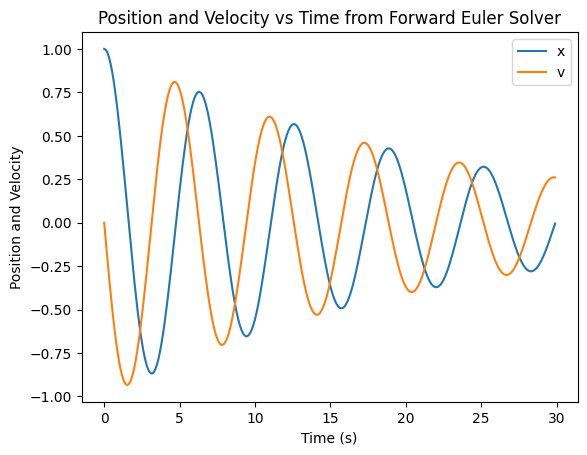

In [8]:
plt.plot(t, ex_sol, label=['x', 'v'])
plt.xlabel('Time (s)')
plt.ylabel('Position and Velocity')
plt.title('Position and Velocity vs Time from Forward Euler Solver')
plt.legend()
plt.show()